# Assignment 3

**Course:** AI in Health Technologies (ELEC-E8739), Fall 2025

**Instructor:** Prof. Aleksei Tiulpin, PhD

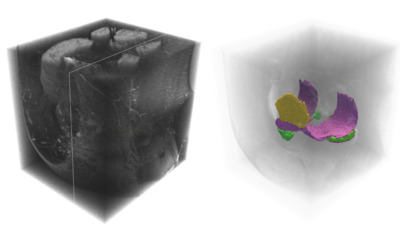

## 1. About

The idea of the present assignment is to practice medical image segmentation. In this assignment, you will learn how to do slice-by-slice segmentation, and understand the validation pitfalls. By completing this assignment, you will learn how to:

1. **Build** simple medical image segmentation pipelines
2. **Re-use** code for different purposes.
3. **Master** design patters, such as inheritance and Mixin.



### 1.1 References and the topic
Similarly to the previous assignment, you will replicating one of the papers on knee osteoarthritis. We will base this assignment on the ideas from the following two papers:

1. Panfilov, E., Tiulpin, A., Klein, S., Nieminen, M. T., & Saarakkala, S. (2019). Improving robustness of deep learning based knee mri segmentation: Mixup and adversarial domain adaptation. In Proceedings of the IEEE/CVF international conference on computer vision workshops (pp. 0-0).
2. Panfilov, E., Tiulpin, A., Nieminen, M. T., Saarakkala, S., & Casula, V. (2022). Deep learning‐based segmentation of knee MRI for fully automatic subregional morphological assessment of cartilage tissues: data from the osteoarthritis initiative. Journal of Orthopaedic Research®, 40(5), 1113-1124.

### 1.2 Why is this important?

So far, there are no treatments for osteoarthritis that can reverse the course of the diseases. The best tool one has, is MRI, and quantifying changes in the disease is extremely difficult. We have therefor developed tools to advance research and drug development. An example would be our pipeline from 2022:

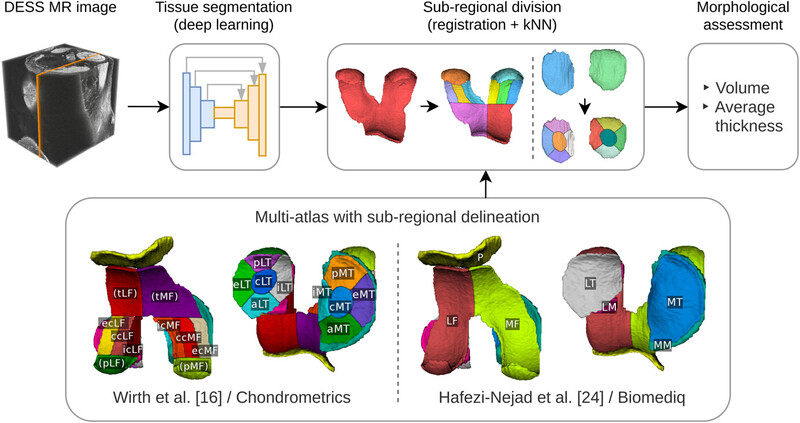

We note that you will not need to do the full pipeline in this assignment, and only focus on the segmentation part, as well as data wrangling.

## 2. Imports

In [1]:
!pip install solt nibabel segmentation_models_pytorch

import torch
import solt
import gc
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import solt
import random
import solt.transforms as slt
import matplotlib
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm.notebook import tqdm
import segmentation_models_pytorch as smp
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.model_selection import train_test_split

SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Fixing one of the most annoying "features" of opencv
cv2.ocl.setUseOpenCL(False)
cv2.setNumThreads(0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.1 MB/s eta 0:00:00


## 3. Getting the data

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/Colab\ Notebooks/Cartilage_segmentation_data_AI4Health | head

9040390_00m_R_img.nii.gz
9040390_00m_R_mask.nii.gz
9040390_12m_R_img.nii.gz
9040390_12m_R_mask.nii.gz
9054866_00m_R_img.nii.gz
9054866_00m_R_mask.nii.gz
9054866_12m_R_img.nii.gz
9054866_12m_R_mask.nii.gz
9087863_00m_R_img.nii.gz
9087863_00m_R_mask.nii.gz


In [4]:
base_dir = Path("drive/MyDrive/Colab Notebooks/Cartilage_segmentation_data_AI4Health/")

In [5]:
ds = []
for img in base_dir.glob("*_img.nii.*"):
    patient, fu, side, _ = img.name.split("_")
    ds.append({"img": img, "segmask": img.parent / img.name.replace("_img", "_mask"), "ID": patient, "VISIT": fu, "SIDE": side})
ds = pd.DataFrame(ds)
ds.head()

,img,segmask,ID,VISIT,SIDE
0,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,9597990,00m,R
1,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,9967358,12m,R
2,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,9663706,12m,R
3,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,9500390,12m,R
4,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,drive/MyDrive/Colab Notebooks/Cartilage_segmen...,9992358,00m,R


## 4. Data visualization (1p)

Let us visualize some of the samples. For this, let's implement a function that shrinks the raw data stored in the nifty files into an 8 bit range. This is done to remove some parts of the intensity spectrum that are too bright.


In [6]:
def vis_slice(img, lp=0, hp=99.9):
    ########################## YOUR CODE IS HERE (0.5p) ######################
    #
    # This is the algorithm:
    # 0. Convert the data into a 32 bit float.
    # 1. Find the percentile values based on the `lp` and `hp` percentile values.
    # 2. Do a min-max nornalization, scaling the image into a 0-1 range.
    # 3. Scale to 8 bit and return the result as np.unit8
    #

    # convert data into 32 bit float
    img_float = img.astype(np.float32)

    # percentile values
    low = np.percentile(img_float, lp)
    high = np.percentile(img_float, hp)

    # min-max normalization
    img_norm = (img_float - low) / (high - low)
    # if there are outlier pixels below the lp percentile or above the hp percentile
    img_norm = np.clip(img_norm, 0, 1)

    # scale to 8 bit
    img_8bit = (img_norm * 255).astype(np.uint8)

    return img_8bit
    ##########################################################################

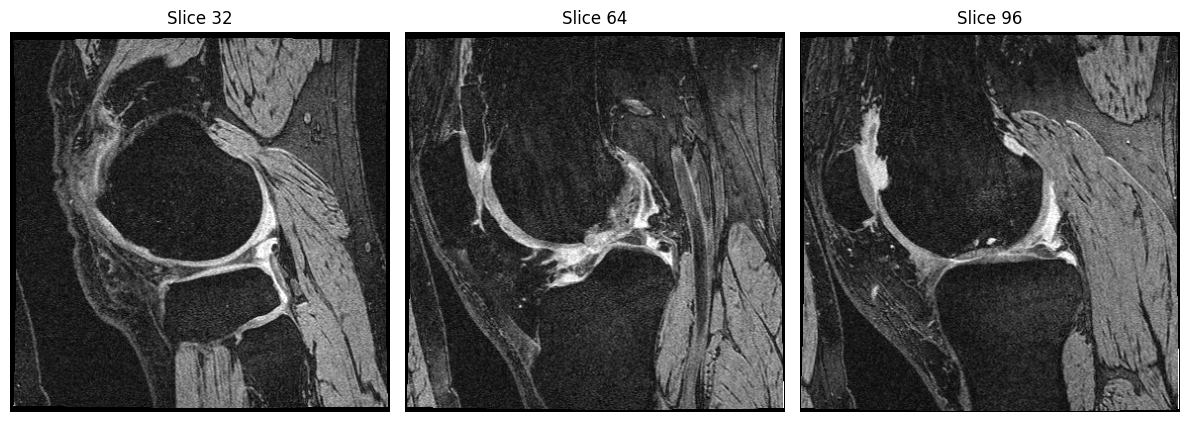

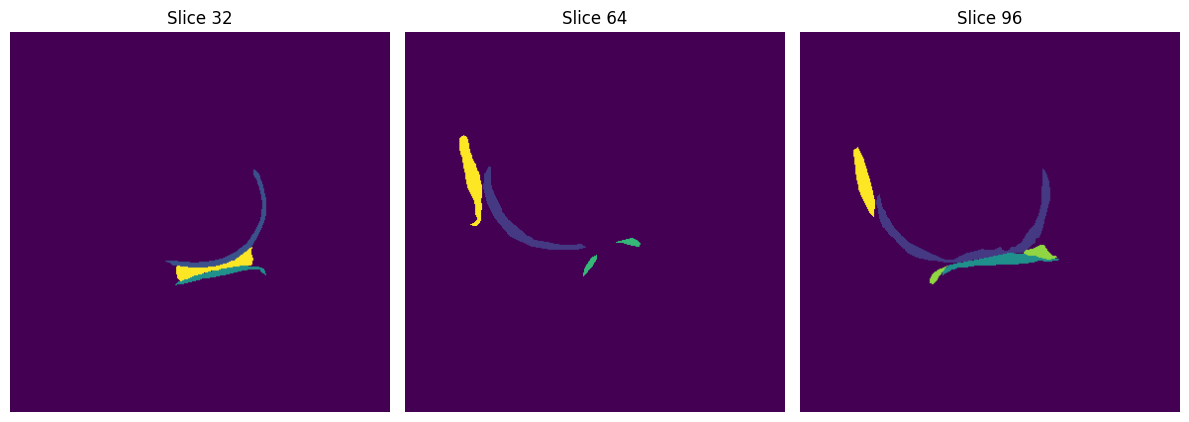

In [7]:
img = nib.load(ds.iloc[0].img)
mask = nib.load(ds.iloc[0].segmask)

########################## YOUR CODE IS HERE (0.5p) ######################
#
# Make a plot to get the figures below. The figure size for each row is (12,5)
# Pay attention to the image orientation
#

img_data = img.get_fdata()
mask_data = mask.get_fdata()

slice_ids = [32, 64, 96]

# MR images
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for ax, sl in zip(axes, slice_ids):
    sl_img = vis_slice(img_data[sl, :, :])
    # adjust orientation
    sl_img = np.rot90(sl_img, k=3)
    sl_img = np.fliplr(sl_img)

    ax.imshow(sl_img, cmap="gray")
    ax.set_title(f"Slice {sl}")
    ax.axis("off")
plt.tight_layout()

# segmentation masks
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for ax, sl in zip(axes, slice_ids):
    sl_mask = mask_data[sl, :, :]
    # same orientation as above
    sl_mask = np.rot90(sl_mask, k=3)
    sl_mask = np.fliplr(sl_mask)

    ax.imshow(sl_mask, cmap="viridis")
    ax.set_title(f"Slice {sl}")
    ax.axis("off")

plt.tight_layout()
##########################################################################

We can now visualize the data using the marching cube algorithm.

In [8]:
mesh_cache = {}
for label in np.unique(mask_data):
    if label == 0:
        continue  # skip background
    mask = (mask_data == label)
    if np.sum(mask) == 0:
        continue

    verts, faces, normals, values = measure.marching_cubes(mask, level=0.5, step_size=2)
    mesh_cache[int(label)] = (verts, faces)
    print(f"Cached label {label} → {len(faces)} faces")

Cached label 1.0 → 49964 faces
Cached label 2.0 → 7800 faces
Cached label 3.0 → 8674 faces
Cached label 4.0 → 7834 faces
Cached label 5.0 → 8402 faces
Cached label 6.0 → 11572 faces


In [9]:
def render_3d_mask(mesh_cache, shape, colors, elev=120, azim=120, alpha=0.3):
    fig = plt.figure(figsize=(5, 10), dpi=300)
    for plot_idx, azim_i in zip(range(4), (azim, azim//2, -azim//2, -azim)):
        ax = fig.add_subplot(1,4, 1+plot_idx, projection='3d')
        for label, (verts, faces) in mesh_cache.items():
            mesh = Poly3DCollection(verts[faces], alpha=alpha)
            mesh.set_facecolor(colors(int(label)))
            mesh.set_edgecolor('none')
            ax.add_collection3d(mesh)

        ax.set_xlim(0, shape[0])
        ax.set_ylim(0, shape[1])
        ax.set_zlim(0, shape[2])
        ax.set_box_aspect((1, 1, 1))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.view_init(elev=elev, azim=azim_i)

    plt.tight_layout()
    plt.show()

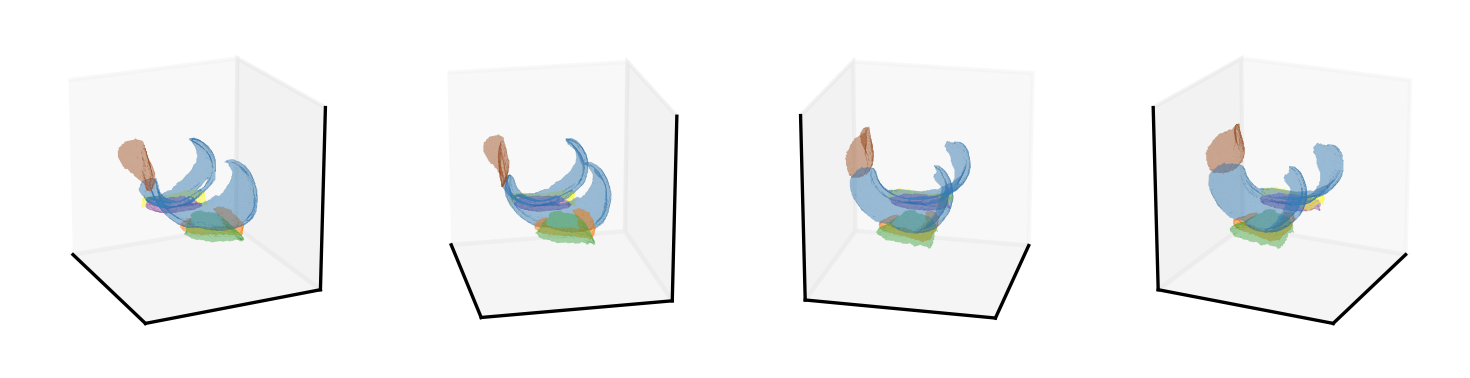

In [ ]:
render_3d_mask(mesh_cache, mask_data.shape, matplotlib.colormaps['Set1'], 200, 25)

## 5. Slice caching, data loading, and augmentation (3p)

We have quite a low amount of memory, and we thus need to be very selective on how we segment.

A very simple strategy, is to train segmentation slice-wise. We, however, should first cache the data. We have done something similar in one of the lectures. Here, we will use parallel data processing to speed up the processing. Your task is to implement the functionality.

In [10]:
dataset_local_dir = Path("/content/dataset_slices/")

(dataset_local_dir / "images").mkdir(exist_ok=True, parents=True)
(dataset_local_dir / "masks").mkdir(exist_ok=True, parents=True)


########################## YOUR CODE IS HERE (2p) #############################
#
# The algorithm involves processing the rows of `ds` in parallel.
# Here is what you need to do:
#
# 1. Implement a function that processes one row of `ds`.
#    This function needs to load image and mask (see the plotting example),
#    and save the files into dataset_local_dir / "images" (for images) and
#    dataset_local_dir / "masks" (for masks). The files need to be in the PNG
#    format. Do not forget the transposition (see visualization of the slices).
#
# 2. Parallelize the execution of the data processing by iterating over the rows of
#    the dataset `ds`, and use a PoolExecutor to submit the tasks.
#    Docs docs here: https://docs.python.org/3/library/concurrent.futures.html.
#    Create a pandas dataframe `slice_ds`.
#
# The resulting dataframe needs to store: subject id, side, visit, slice index,
# the path to the image, and the path to the mask.
# You can see how the dataframe content should look like below.
#

def process_row(item):
    idx, row = item

    img = nib.load(row.img)
    mask = nib.load(row.segmask)

    img_data = img.get_fdata()
    mask_data = mask.get_fdata()

    out_rows = []

    # iterate over sagittal slices (axis 0)
    for sl in range(img_data.shape[0]):
        # IMAGE
        sl_img = img_data[sl, :, :]           # sagittal slice
        sl_img = vis_slice(sl_img)            # contrast / percentile scaling
        # geometric transforms (same as in your visualization)
        sl_img = np.rot90(sl_img, k=3)
        sl_img = np.fliplr(sl_img)

        # MASK
        sl_mask = mask_data[sl, :, :]
        sl_mask = np.rot90(sl_mask, k=3)
        sl_mask = np.fliplr(sl_mask)
        # ensure uint8 label image (0/1 or small integers)
        sl_mask = sl_mask.astype(np.uint8)

        # common filename for image + mask
        slice_name = f"{row.ID}_{row.VISIT}_{row.SIDE}_slice{sl:03d}.png"
        img_path  = dataset_local_dir / "images" / slice_name
        mask_path = dataset_local_dir / "masks" / slice_name

        # save with OpenCV (grayscale)
        cv2.imwrite(str(img_path), sl_img)
        cv2.imwrite(str(mask_path), sl_mask)

        out_rows.append({
            "ID": row.ID,
            "SIDE": row.SIDE,
            "VISIT": row.VISIT,
            "slice_idx": sl,
            "img": str(img_path),
            "segmask": str(mask_path),
        })

    return out_rows


# parallel processing over all rows of ds
all_rows = []

# ds.iterrows() yields (index, row) pairs, which we pass to process_row
with ProcessPoolExecutor(max_workers=mp.cpu_count()) as ex:
    for result in ex.map(process_row, ds.iterrows()):
        all_rows.extend(result)

slice_ds = pd.DataFrame(all_rows)
###############################################################################

In [ ]:
slice_ds.head()

,ID,SIDE,VISIT,slice_idx,img,segmask
0,9597990,R,00m,0,/content/dataset_slices/images/9597990_00m_R_s...,/content/dataset_slices/masks/9597990_00m_R_sl...
1,9597990,R,00m,1,/content/dataset_slices/images/9597990_00m_R_s...,/content/dataset_slices/masks/9597990_00m_R_sl...
2,9597990,R,00m,2,/content/dataset_slices/images/9597990_00m_R_s...,/content/dataset_slices/masks/9597990_00m_R_sl...
3,9597990,R,00m,3,/content/dataset_slices/images/9597990_00m_R_s...,/content/dataset_slices/masks/9597990_00m_R_sl...
4,9597990,R,00m,4,/content/dataset_slices/images/9597990_00m_R_s...,/content/dataset_slices/masks/9597990_00m_R_sl...


Let us now implemeng the dataset

In [11]:
class KneeSegmentationDataset(Dataset):
    def __init__(self, df, transforms):
    ########################## YOUR CODE IS HERE (1p) #######################
    #
    # Implement a standard PyTorch dataset that would be loading
    # the image and the mask, and return a dict. Do not forget the data
    # augmentation.
    #

        self.dataset = df
        self.trf = transforms

    def __getitem__(self, idx):
        entry = self.dataset.iloc[idx]

        # image: 3-channel, mask: single-channel
        img  = cv2.imread(entry.img) # H, W, 3
        mask = cv2.imread(entry.segmask, cv2.IMREAD_GRAYSCALE) # H, W

        # data augmentation
        if self.trf is not None:
            dc = self.trf({'image': img, 'mask': mask}, return_torch=False)
            img, mask = dc.data   # img: H,W,3 ; mask: H,W

        # convert to tensors
        img = img.astype(np.float32) / 255.0        # [0, 1]
        mask = mask.astype(np.int64)               # class labels (0..C-1)

        # to CHW
        img_tensor  = torch.from_numpy(img).permute(2, 0, 1)   # (3,H,W)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)      # (1,H,W)

        return {
            "image": img_tensor,
            "mask": mask_tensor,
        }

    def __len__(self):
        return self.dataset.shape[0]
    ###########################################################################

Augmentations for segmentation are a bit tricky. You need to make sure that you do not add interpolation artifacts too much, and use the nearest neigbor interpolation. We will define a very simple transform here first.

In [12]:
stream = solt.Stream([
    slt.Flip(p=0.5, axis=1),
    slt.Rotate((-10, 10), p=0.5),
    slt.Crop((320, 320), crop_mode="r"),
    slt.GammaCorrection(gamma_range=0.1, p=1),
])

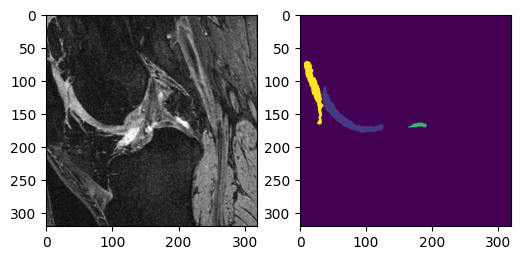

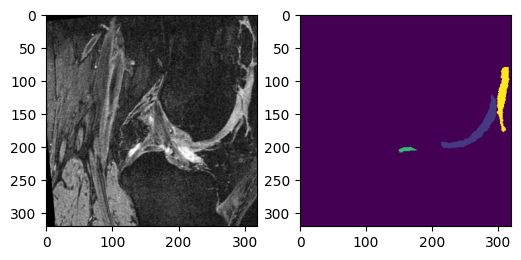

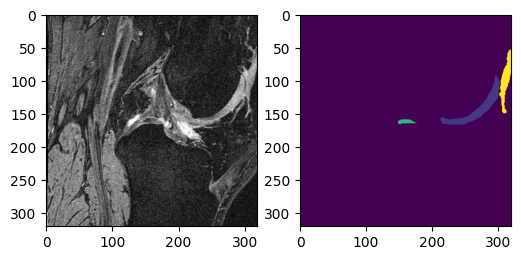

In [ ]:
img = cv2.imread(slice_ds.iloc[70].img)
mask = cv2.imread(slice_ds.iloc[70].segmask, 0)
for i in range(3):
    img_aug, mask_aug = stream({'image': img, 'mask': mask}, return_torch=False).data
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(img_aug)
    axes[1].imshow(mask_aug.astype(float))
    plt.show()

## 6. Segmentation models framework

The example below is a direct copypaste from the official github page. As toy can see, we can initialize a model with an encoder, which is a resnet34,
and a decoder, which is a Unet. The segmentation model offers many options we can play with.

```
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
)

```

Let's test if we can push a large image through the model:

In [13]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
)

out = model(torch.zeros((1, 3, 320, 320), dtype=torch.float32))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
print(out.shape)

torch.Size([1, 3, 320, 320])


## 7. Trainer (6p)

As can be seen, the image gets pushed w/o any problems. We can now define a trainer. The trainer is a modification of of the trainer from Assignment 2 and the lectures. You just need to fill in the blanks.

Here, you will design a basic trainer: the one that is generic, and will implement a subclass, which will be tailored to slice-wise segmentation. Finally, we will add a validation function that analyzes the data volumetrically.

In [14]:
# Base trainer implementation gives you 1 point.
#
# We will largely re-use the implementation from A2, however,
# We will also add some new features, like inheritance and more
# flexible configs.

class BaseTrainer:
    def __init__(self, train_df, val_df, cfg):
        self.train_df = train_df
        self.val_df = val_df

        # A good style is to define variables before we use them
        # If nothing is stored, we just store `None`.
        self.train_loader = None
        self.val_loader = None
        self.loss_fn = None
        self.optimizer = None
        self.model = None

        # Data loader params
        self.cfg = cfg

    def init_model(self):
        raise NotImplementedError

    def init_run(self):
        del self.train_loader
        del self.val_loader
        del self.optimizer

        gc.collect()
        torch.cuda.empty_cache()

        self.init_model()
        ########################## YOUR CODE IS HERE (0.25p) #############################
        #
        # Implement data loaders.
        #
        # Instructions:
        # 1. Use `self.cfg.dataset_train_cls` to create the training dataset.
        # 2. Use `self.cfg.dataset_val_cls` to create the validation dataset.
        # 3. Create `self.train_loader` and `self.val_loader` using `DataLoader`.
        # 4. For the train loader, shuffle the dataset.
        # 5. Use batch size and number of workers from `self.cfg` for both loaders.
        # 6. You must follow this exact pattern for integration with the trainer loop.
        #

        train_ds = self.cfg.dataset_train_cls(
            self.train_df,
            self.cfg.train_trf
        )

        val_ds = self.cfg.dataset_val_cls(
            self.val_df,
            self.cfg.val_trf,
        )

        self.train_loader = DataLoader(
            train_ds,
            batch_size=self.cfg.train_bs,
            shuffle=True,
            num_workers=self.cfg.n_workers,
            pin_memory=True
        )

        self.val_loader = DataLoader(
            val_ds,
            batch_size=self.cfg.val_bs,
            shuffle=False,
            num_workers=self.cfg.n_workers,
            pin_memory=True
        )
        ###############################################################################

        ########################## YOUR CODE IS HERE (0.25p) #############################
        #
        # Implement optimizer and loss function setup.
        #
        # Instructions:
        # 1. Create an optimizer using `self.cfg.optimizer_cls`.
        # 2. Pass `self.model.parameters()` and learning rate + weight decay from `self.cfg`.
        # 3. Set `self.loss_fn` using `self.cfg.loss_fn`.
        # 4. This is required so the training loop can compute gradients and update weights.
        #
        self.optimizer = self.cfg.optimizer_cls(
            self.model.parameters(),
            lr=self.cfg.lr,
            weight_decay=self.cfg.wd
        )

        self.loss_fn = self.cfg.loss_fn
        ###############################################################################

    def adjust_lr(self):
        if self.epoch in self.cfg.lr_drop_milestones:
            for param_group in self.optimizer.param_groups:
                param_group["lr"] *= 0.1

    def run(self, n_epochs=None):
        self.init_run()
        if n_epochs is None:
            n_epochs = self.cfg.num_epochs
        for self.epoch in range(n_epochs):
            # Here, we set the model to train
            # This enables learning of the BatchNorm statistics and
            # enables the dropout
            self.model.train()
            train_loss = self.train_epoch()

            # Eval mode is contrary to the train
            # It sets the dropout off and uses already learned
            # BatchNorm stats
            self.model.eval()
            val_out = self.val_epoch()
            self.post_val_hook(train_loss, val_out)

    def train_epoch(self):
        ##################### YOUR CODE IS HERE (0.25p) #####################
        #
        # Implement the training of one epoch.
        #
        # Just re-use from Assignment 2. It does not really change.
        #

        sys.stderr.flush()
        pbar = tqdm(total=len(self.train_loader), position=0, leave=True)

        running_loss = torch.tensor(0., requires_grad=False).to(self.cfg.device)

        self.adjust_lr()

        for i, batch in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            loss, _ = self.pass_batch(batch)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            cur_loss = running_loss.item() / (i + 1)

            desc = f'[{self.epoch}] Train {loss.item():.4f} / {cur_loss:.4f}'
            pbar.set_description(desc)
            pbar.update()

        pbar.close()
        running_loss = running_loss.div_(len(self.train_loader))

        return running_loss.item()
        ######################################################################

    def val_epoch(self):
        raise NotImplementedError

    def post_val_hook(self, train_loss, val_out):
        sys.stderr.flush()
        print("="*50)
        print(f"[{self.epoch}] --> Train loss :{train_loss:.4f}")
        print(f"[{self.epoch}] --> Val loss :{val_out["val_loss"]:.4f}")
        print("="*50)

    def pass_batch(self, batch):
        ##################### YOUR CODE IS HERE (0.25p) #####################
        #
        # Implement the `pass_batch` function
        #
        # Just re-use the idea from Assignment 2, execept here, you
        #

        img = batch["image"].to(self.cfg.device)      # shape: (N, C, H, W)
        segmask = batch["mask"].to(self.cfg.device) # shape: (N, 1, H, W)

        # segmentation model takes only the image
        logits = self.model(img) # shape: (N, C, H, W)

        # Define target for the loss:
        # For CrossEntropyLoss: target shape (N, H, W), dtype long
        target = segmask.squeeze(1).long() # remove channel dim

        # Compute loss
        loss = self.loss_fn(logits, target)

        return loss, logits
        ######################################################################

Let us now implement a specific trainer for slice-wise segmentation:

In [15]:
class SegmentationTrainer2D(BaseTrainer):
    ########################## YOUR CODE IS HERE (4p) #############################
    #
    # Implement the trainer. To make a functional trainer class,
    # You need to override several methods and add some new ones.
    #
    # 1. Override `init_model` method. Use a model with a Unet decoder
    #    and specify the encoder via the config. Start from imagenet weights
    #    Note the config structure. The number of output classes is the length
    #    of the class names array.
    #
    # 2. Write compute_jaccard method. This needs to compute a class-wise
    #    Jaccard index per class, and return a list of dicts for a batch
    #    (one dict per item). The implementation must use torch and
    #    work on the GPU.
    #
    # 3. Override the `val_epoch` method to perform slice-wise validation.
    #    Here is the workflow:
    #      - We make prediction with the model (at a batch level)
    #      - For every pixel, we make the prediction of the most probable class
    #      - Pass the result into the jaccard computation method.
    #      - Extend your list of Jaccard dicts
    #      - At the end of the validation, do aggregation and return a dict
    #        of means over the validation dataset. `val_epoch` must return a dict
    #
    # 4. Override the `post_val_hook` to output Jaccard by class.
    #

    def init_model(self):
        self.model = smp.Unet(
            encoder_name=self.cfg.backbone,
            encoder_weights="imagenet",
            in_channels=3,
            classes=len(self.cfg.class_names),
        ).to(self.cfg.device)

    def compute_jaccard(self, logits, target):
        # Ensure target has shape (N, H, W)
        if target.dim() == 4:
            target = target.squeeze(1)

        # Predictions: class with max logit
        preds = torch.argmax(logits, dim=1)  # (N, H, W)

        num_classes = len(self.cfg.class_names)
        batch_size = preds.size(0)

        results = []

        # Loop over batch
        for i in range(batch_size):
            item_res = {}
            p = preds[i]   # (H, W)
            t = target[i]  # (H, W)

            # Loop over classes
            for c, cname in enumerate(self.cfg.class_names):
                pred_c = (p == c)
                true_c = (t == c)

                # Intersection and union on GPU
                inter = (pred_c & true_c).sum().float()
                union = (pred_c | true_c).sum().float()

                union_zero = (union == 0)

                iou = torch.where(
                    union_zero,
                    torch.tensor(1.0, device=union.device),
                    inter.float() / (union.float() + 1e-7)
                )

                item_res[cname] = iou.item()  # convert to Python float

            results.append(item_res)

        return results

    def val_epoch(self):
        self.model.eval()

        running_loss = 0.0
        all_jaccards = []   # list of dicts, one per item

        with torch.no_grad():
            pbar = tqdm(total=len(self.val_loader), position=0, leave=False)

            for i, batch in enumerate(self.val_loader):
                img = batch["image"].to(self.cfg.device)
                mask = batch["mask"].to(self.cfg.device)

                # forward pass
                logits = self.model(img) # (N,C,H,W)

                # loss: CrossEntropyLoss expects (N,C,H,W) and (N,H,W) long
                target = mask.squeeze(1).long()
                loss   = self.loss_fn(logits, target)

                running_loss += loss.item()

                # compute per-item Jaccards (list of dicts)
                batch_jaccards = self.compute_jaccard(logits, mask)
                all_jaccards.extend(batch_jaccards)

                desc = f"[{self.epoch}] Val {loss.item():.4f}"
                pbar.set_description(desc)
                pbar.update()

            pbar.close()

        # mean validation loss
        mean_val_loss = running_loss / len(self.val_loader)

        # aggregate IoU per class over all items
        # all_jaccards: list of dicts {class_name: iou}
        agg = {c: [] for c in self.cfg.class_names}
        for d in all_jaccards:
            for cname, iou in d.items():
                agg[cname].append(iou)

        mean_iou = {}
        for cname in self.cfg.class_names:
            if len(agg[cname]) > 0:
                mean_iou[cname] = float(np.mean(agg[cname]))
            else:
                mean_iou[cname] = 0.0

        # build return dict; must contain "val_loss"
        out = {"val_loss": mean_val_loss}
        # optionally add per-class IoUs with clear keys
        for cname, v in mean_iou.items():
            out[f"jaccard/{cname}"] = v

        return out

    def post_val_hook(self, train_loss, val_out):
        sys.stderr.flush()
        print("=" * 50)
        print(f"[{self.epoch}] --> Train loss : {train_loss:.4f}")
        print(f"[{self.epoch}] --> Val loss   : {val_out['val_loss']:.4f}")

        # Print Jaccard per class
        for cname in self.cfg.class_names:
            key = f"jaccard/{cname}"
            if key in val_out:
                print(f"    Jaccard [{cname}] : {val_out[key]:.4f}")

        print("=" * 50)
    ###########################################################################

In [16]:
########################## YOUR CODE IS HERE (1p) #############################
#
# Implement a correct split of your data
# You need to end up with a train_df, val_df, and test df.
# You train_df + val df need to be 80% of the original data
# The validation part is 20% of dataset \ test_set.
#

# create patient identifier (ID + SIDE)
patients = slice_ds['ID'].astype(str) + "_" + slice_ds['SIDE']
unique_patients = patients.unique()

# split 80% train+val, 20% test
train_val_patients, test_patients = train_test_split(
    unique_patients,
    test_size=0.20,
    random_state=42,
)

# split train_val into train (80%) and val (20%)
train_patients, val_patients = train_test_split(
    train_val_patients,
    test_size=0.20,
    random_state=42,
)

# build the final slice-level DataFrames
train_df = slice_ds[patients.isin(train_patients)].reset_index(drop=True)
val_df   = slice_ds[patients.isin(val_patients)].reset_index(drop=True)
test_df  = slice_ds[patients.isin(test_patients)].reset_index(drop=True)

# Debug prints
print(f"Train patients: {len(train_patients)} → {len(train_df)} slices")
print(f"Val   patients: {len(val_patients)} → {len(val_df)} slices")
print(f"Test  patients: {len(test_patients)} → {len(test_df)} slices")
################################################################################

Train patients: 28 → 8320 slices
Val   patients: 8 → 2080 slices
Test  patients: 9 → 2720 slices


In [17]:
class Cfg:
    device = torch.device("cuda:0")
    backbone="vgg11_bn"

    dataset_train_cls = KneeSegmentationDataset
    dataset_val_cls = KneeSegmentationDataset

    optimizer_cls = torch.optim.AdamW
    data_tag = "image"
    target_tag = "mask"

    class_names = [
        "BG",
        "FemoralCartilage",
        "LateralTibialCartilage",
        "MedialTibialCartilage",
        "LateralMeniscus",
        "MedialMeniscus",
        "PatellarCartilage"

    ]
    wd = 5e-5
    lr = 1e-3

    num_epochs = 50
    n_workers = mp.cpu_count()
    train_bs = 32
    val_bs = 8

    lr_drop_milestones = [30, ]

    loss_fn = torch.nn.CrossEntropyLoss()

    # We need a more compute-friendly setup
    train_trf = solt.Stream([
        slt.Resize((256, 256)),
        slt.Flip(p=0.5, axis=1),
        slt.Crop((224, 224), crop_mode="r"),
        slt.GammaCorrection(gamma_range=0.1, p=1),
    ])

    val_trf = solt.Stream([
        slt.Resize((256, 256))
    ])

In [ ]:
trainer = SegmentationTrainer2D(train_df, val_df, Cfg())

In [ ]:
trainer.run(3)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

[0] --> Train loss : 0.1942
[0] --> Val loss   : 0.0237
    Jaccard [BG] : 0.9936
    Jaccard [FemoralCartilage] : 0.7525
    Jaccard [LateralTibialCartilage] : 0.7458
    Jaccard [MedialTibialCartilage] : 0.7188
    Jaccard [LateralMeniscus] : 0.6609
    Jaccard [MedialMeniscus] : 0.7284
    Jaccard [PatellarCartilage] : 0.7558


  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

[1] --> Train loss : 0.0219
[1] --> Val loss   : 0.0154
    Jaccard [BG] : 0.9945
    Jaccard [FemoralCartilage] : 0.8063
    Jaccard [LateralTibialCartilage] : 0.8761
    Jaccard [MedialTibialCartilage] : 0.7188
    Jaccard [LateralMeniscus] : 0.8391
    Jaccard [MedialMeniscus] : 0.7284
    Jaccard [PatellarCartilage] : 0.7790


  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

[2] --> Train loss : 0.0167
[2] --> Val loss   : 0.0152
    Jaccard [BG] : 0.9951
    Jaccard [FemoralCartilage] : 0.7649
    Jaccard [LateralTibialCartilage] : 0.8735
    Jaccard [MedialTibialCartilage] : 0.8005
    Jaccard [LateralMeniscus] : 0.8671
    Jaccard [MedialMeniscus] : 0.7284
    Jaccard [PatellarCartilage] : 0.8077


## 8. High resolution training

We can make easy adjustments to our setup and make the code work with high res data.

In [18]:
class CfgHighRes(Cfg):
    # Here we will go beyond the lowres case
    train_trf = solt.Stream([
        slt.Flip(p=0.5, axis=1),
        slt.Crop((320, 320), crop_mode="r"),
        slt.GammaCorrection(gamma_range=0.1, p=1),
    ])

    val_trf = solt.Stream([
    ])

In [ ]:
trainer = SegmentationTrainer2D(train_df, val_df, CfgHighRes())

In [ ]:
trainer.run(3)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

[0] --> Train loss : 0.1939
[0] --> Val loss   : 0.0200
    Jaccard [BG] : 0.9944
    Jaccard [FemoralCartilage] : 0.7893
    Jaccard [LateralTibialCartilage] : 0.8507
    Jaccard [MedialTibialCartilage] : 0.7188
    Jaccard [LateralMeniscus] : 0.8139
    Jaccard [MedialMeniscus] : 0.7284
    Jaccard [PatellarCartilage] : 0.8148


  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

[1] --> Train loss : 0.0217
[1] --> Val loss   : 0.0140
    Jaccard [BG] : 0.9954
    Jaccard [FemoralCartilage] : 0.7937
    Jaccard [LateralTibialCartilage] : 0.8893
    Jaccard [MedialTibialCartilage] : 0.8422
    Jaccard [LateralMeniscus] : 0.8450
    Jaccard [MedialMeniscus] : 0.7284
    Jaccard [PatellarCartilage] : 0.8158


  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

[2] --> Train loss : 0.0170
[2] --> Val loss   : 0.0125
    Jaccard [BG] : 0.9956
    Jaccard [FemoralCartilage] : 0.8044
    Jaccard [LateralTibialCartilage] : 0.9000
    Jaccard [MedialTibialCartilage] : 0.8906
    Jaccard [LateralMeniscus] : 0.8828
    Jaccard [MedialMeniscus] : 0.7284
    Jaccard [PatellarCartilage] : 0.8492


## 9. 3D Evaluation (4 points)

We have so far implemented a pur slice-wise training. Now, let us generaize to 3D. We care about the 3D structures, but do segmentation slice-by-slice. The evaluation can have a simple fix.


This is how we are going to do it:

1. We first assume that full stacks come to us instead of slices.
2. We will initialize a volume with predictions with zeros
3. We will go slice-by-slice and start to gradually fill the 3D volume of predictions.
4. The Jaccard implementation that we have developed does not care if we have have 2D or 3D volume, so, nothing really changes.

To make the above work, we need two modifications:
1. We need to change the validation method.
2. We need change the dataset class.

More detailed instructions are below.

In [19]:
class SegmentationTrainer3D(SegmentationTrainer2D):
########################## YOUR CODE IS HERE (2p) #############################
#
# Implement the method `pass_eval_batch`.
#
# This function evaluates a *3D scan* (stack of slices) by running the model
# **slice-by-slice**, accumulating loss (optional), and assembling the predicted
# 3D mask volume.
#
# What you need to do:
#
# 1. Move `scan` and `target` to the correct device (`self.cfg.device`).
#
# 2. Extract dimensions:
#       batch_size, n_slices, _, H, W = scan.shape
#    You will need these values to create an empty tensor that stores the
#    predictions for all slices.
#
# 3. Create an empty tensor for the predictions:
#       output = torch.zeros(batch_size, n_slices, H, W)
#    Make sure it is created on the same device as the model.
#
# 4. Initialize a loss accumulator (scalar tensor) set to zero.
#
# 5. Loop over slices:
#       for slice_idx in range(n_slices):
#           - Extract the slice image: input tensor with shape (BS, C, H, W)
#           - Extract the slice target: integer mask with shape (BS, H, W)
#           - Pass the image slice through the model
#           - Convert the model output (logits) to predicted class labels using argmax
#             and store it into the correct location in `output`
#           - If compute_loss == True, compute the loss and add it to your accumulator
#
# 6. After the loop, divide the accumulated loss by the number of slices.
#
# 7. Return:
#       loss_i, output, target

    def pass_eval_batch(self, batch, compute_loss: bool = False):
        # move `scan` to the correct device
        scan = batch["scan"].to(self.cfg.device) # (B, S, C, H, W)

        # extract `mask` if present
        target_full = batch.get("mask", None)
        if target_full is not None:
            target_full = target_full.to(self.cfg.device)

        # extract batch_size, n_slices, _, H, W
        batch_size, n_slices, _, H, W = scan.shape

        # number of output classes
        num_classes = len(self.cfg.class_names)

        # normalize target shape to (B, S, H, W) and type to long if present
        if target_full is not None:
            if target_full.dim() == 5: # (B, S, 1, H, W)
                target_full = target_full.squeeze(2)
            target_full = target_full.long() # (B, S, H, W)

        # create an empty tensor for the logits volume
        # shape: (B, C, S, H, W), allocated on the same device as the model
        logits_volume = torch.zeros(
            batch_size, num_classes, n_slices, H, W,
            device=self.cfg.device, dtype=torch.float32
        )

        # initialize loss accumulator
        total_loss = 0.0

        # loop over slices
        for s in range(n_slices):
            # extract the slice image: (B, C, H, W)
            x_s = scan[:, s, ...]

            # forward pass through the model
            logits_s = self.model(x_s) # (B, C, H, W)

            # store slice logits in the full 3D volume
            logits_volume[:, :, s, :, :] = logits_s

            if compute_loss:
                # sanity check: loss requires ground-truth mask
                if target_full is None:
                    raise ValueError("compute_loss=True but batch['mask'] is None.")

                # extract the slice target: (B, H, W)
                y_s = target_full[:, s, ...]

                # compute slice loss and accumulate
                loss_s = self.cfg.loss_fn(logits_s, y_s)
                total_loss += float(loss_s.item())

        # average loss over slices if requested
        loss_i = (total_loss / n_slices) if compute_loss else None

        # return loss, full 3D logits volume, and full 3D target
        return loss_i, logits_volume, target_full
###############################################################################

########################## YOUR CODE IS HERE (1p) #############################
#
# Implement the method `val_epoch`.
#
# This method evaluates the model on the **entire validation dataset**.
# You will compute both:
#   - the average validation loss
#   - the Jaccard (IoU) score for each class
#
# What you need to do:
#
# 1. Disable gradient computation using `torch.no_grad()`.
#
# 2. Initialize:
#       - running_loss = 0 (as a tensor on the correct device)
#       - a list where you will store Jaccard scores computed for each batch
#
# 3. Create a tqdm progress bar iterating over `self.val_loader`.
#
# 4. For each batch:
#       - Extract the 3D scan and the target mask:
#             scan = batch["scan"]
#             target = batch["mask"]
#       - Call `self.pass_eval_batch(...)` with compute_loss=True
#       - Accumulate the loss
#       - Compute Jaccard scores for this prediction:
#             jaccard_per_class = self.compute_jaccard(pred, target)
#         Append these results to your global list
#
# 5. After the loop:
#       - Divide the total loss by the number of validation batches
#       - Convert the collected Jaccard scores into a pandas DataFrame
#       - For each class in `self.cfg.class_names`, compute the mean IoU
#
# 6. Return a dictionary with:
#       {
#         "val_loss": <average validation loss>,
#         "jaccard": <dict: class_name -> mean IoU>
#       }
#

    @torch.no_grad()
    def val_epoch(self):
        # set model to evaluation mode
        self.model.eval()

        # init running_loss = 0 (scalar float)
        running_loss = 0.0

        # list of per-item Jaccard dicts (one per slice)
        all_jaccards = []

        # initialize progress bar over validation loader
        pbar = tqdm(self.val_loader, desc=f"[{self.epoch}] Val", leave=False)

        # loop over validation batches
        for batch in pbar:
            # evaluate one volume (slice-by-slice inside pass_eval_batch)
            loss_i, logits_vol, target_vol = self.pass_eval_batch(batch, compute_loss=True)

            # accumulate loss
            running_loss += float(loss_i)

            # reshape logits from (B, C, S, H, W) to (B*S, C, H, W)
            B, C, S, H, W = logits_vol.shape
            logits_flat = (
                logits_vol
                .permute(0, 2, 1, 3, 4)
                .contiguous()
                .view(B * S, C, H, W)
            )

            # reshape targets from (B, S, H, W) to (B*S, H, W)
            target_flat = target_vol.contiguous().view(B * S, H, W)

            # compute per-item Jaccards (list of dicts)
            batch_jaccards = self.compute_jaccard(logits_flat, target_flat)
            all_jaccards.extend(batch_jaccards)

            # update progress bar with current loss
            pbar.set_postfix({"loss": f"{loss_i:.4f}"})

        # mean validation loss over all batches
        mean_val_loss = running_loss / max(1, len(self.val_loader))

        # aggregate IoU per class over all items
        agg = {c: [] for c in self.cfg.class_names}
        for d in all_jaccards:
            for cname, iou in d.items():
                agg[cname].append(iou)

        # compute mean IoU per class
        mean_iou = {}
        for cname in self.cfg.class_names:
            mean_iou[cname] = float(np.mean(agg[cname])) if len(agg[cname]) > 0 else 0.0

        # build return dict contain ing"val_loss" and jaccard/<class>
        out = {"val_loss": mean_val_loss, "jaccard": mean_iou}
        for cname, v in mean_iou.items():
            out[f"jaccard/{cname}"] = v

        return out
###############################################################################

The biggest challenge is the dataset class. This is where we need to be extremely careful and consider that we need to group data by scan. We can use pandas grouping features to get the dataset into the needed shape.

In [20]:
class KneeSegmentationDatasetVol(Dataset):
    def __init__(self, df, transforms, load_mask: bool = True):
        super().__init__()
        self.df = df
        self.trf = transforms
        self.load_mask = load_mask

        self.scans = []
        for _, g in self.df.groupby(["ID", "SIDE", "VISIT"]):
            g = g.sort_values(by="slice_idx").reset_index(drop=True)
            self.scans.append(g)

    ########################## YOUR CODE IS HERE (1p) #############################
    #
    # Implement the method `load_volume`.
    #
    # This method loads a *3D volume* composed of multiple 2D slices.
    # The volume is represented by a dataframe `vol_df`, where each row corresponds
    # to one slice belonging to the same subject, side, and visit.
    #
    # What you need to do:
    #
    # 1. The dataframe `vol_df` must be sorted by slice index before loading
    #    (this is already handled in the constructor).
    #
    # 2. Iterate over all slices in the dataframe:
    #       - Read each image from the path stored in `entry.img` using cv2.imread.
    #       - If `load_mask=True`, load the corresponding mask using
    #         cv2.imread(..., cv2.IMREAD_GRAYSCALE).
    #       - Append the loaded images/masks to Python lists.
    #
    # 3. Apply the provided transform:
    #       res = transform({"images": images, "masks": masks})
    #    The transform returns augmented image tensors and mask tensors.
    #
    # 4. Stack the transformed slices into 3D tensors:
    #
    #    Remember:
    #       - The scan tensor has shape (N_SLICES, C, H, W)
    #       - The mask tensor has shape (N_SLICES, H, W)
    #       - Mask must be in "long", so that cross-entropy works.
    #
    # 5. Return a dictionary with:
    #       {"scan": scan, "mask": mask}
    #
    ###############################################################################

    @staticmethod
    def load_volume(vol_df, transform, load_mask: bool = True, bgr_to_rgb: bool = False):
        images, masks = [], []

        # iterate over all slices in the volume dataframe
        for _, entry in vol_df.iterrows():
            # read each image from the path stored in `entry.img`
            img = cv2.imread(entry.img, cv2.IMREAD_COLOR)
            assert img is not None, f"Failed to read image: {entry.img}"

            # optionally convert from BGR to RGB
            if bgr_to_rgb:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # append the loaded image to the Python list
            images.append(img)

            # if `load_mask=True`, load the corresponding mask in grayscale
            if load_mask:
                m = cv2.imread(entry.segmask, cv2.IMREAD_GRAYSCALE)
                assert m is not None, f"Failed to read mask: {entry.segmask}"
                # append the loaded mask to the Python list
                masks.append(m)

        # apply the provided transform to the list of slices
        # the transform returns augmented tensors
        if load_mask:
            res = transform({"images": images, "masks": masks})
        else:
            res = transform({"images": images})

        # stack transformed image slices into a 3D tensor
        # resulting shape: (N_SLICES, C, H, W)
        scan_t = torch.stack(res["images"], dim=0)

        if load_mask:
            # normalize each mask slice to shape (H, W) and dtype long
            norm_masks = []
            for m in res["masks"]:
                # mask can be (H, W) or (1, H, W) depending on transforms
                if m.dim() == 3 and m.size(0) == 1:
                    m = m.squeeze(0) # (H, W)
                elif m.dim() != 2:
                    raise ValueError(f"Unexpected per-slice mask shape: {tuple(m.shape)}")

                # ensure mask is in long format for cross-entropy loss
                norm_masks.append(m.long())

            # stack mask slices into a 3D tensor
            # resulting shape: (N_SLICES, H, W)
            mask_t = torch.stack(norm_masks, dim=0)
        else:
            mask_t = None

        # return augmented image tensor and mask tensor
        return {"scan": scan_t, "mask": mask_t}

    def __getitem__(self, index):
        return KneeSegmentationDatasetVol.load_volume(self.scans[index], self.trf, load_mask=self.load_mask, bgr_to_rgb=False)

    def __len__(self):
        return len(self.scans)

In [21]:
vol_ds = KneeSegmentationDatasetVol(slice_ds, solt.Stream([slt.Resize((256, 256))]))

In [ ]:
%%time
vol_data = vol_ds[0]

CPU times: user 807 ms, sys: 179 ms, total: 985 ms
Wall time: 1.01 s


In [ ]:
assert vol_data["scan"].size() == (160, 3, 256, 256)
assert vol_data["mask"].size() == (160, 256, 256)

In [22]:
class CfgVol(Cfg):
    dataset_val_cls = KneeSegmentationDatasetVol
    val_bs = 2

# here we use the mixing pattern
class CfgVolHighRes(CfgVol, CfgHighRes):
    pass

In [ ]:
assert CfgVolHighRes.train_bs == 32
assert CfgVolHighRes.val_bs == 2
assert CfgVolHighRes.dataset_val_cls == KneeSegmentationDatasetVol

In [ ]:
trainer = SegmentationTrainer3D(train_df, val_df, CfgVol())

In [ ]:
trainer.run(3)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

  0%|          | 0/260 [00:00<?, ?it/s]

[0] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[0] --> Train loss : 0.1951
[0] --> Val loss   : 0.0989
    Jaccard [BG] : 0.9860
    Jaccard [FemoralCartilage] : 0.2841
    Jaccard [LateralTibialCartilage] : 0.6990
    Jaccard [MedialTibialCartilage] : 0.7188
    Jaccard [LateralMeniscus] : 0.7029
    Jaccard [MedialMeniscus] : 0.7284
    Jaccard [PatellarCartilage] : 0.6332


  0%|          | 0/260 [00:00<?, ?it/s]

[1] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[1] --> Train loss : 0.0221
[1] --> Val loss   : 0.1420
    Jaccard [BG] : 0.9862
    Jaccard [FemoralCartilage] : 0.2872
    Jaccard [LateralTibialCartilage] : 0.6990
    Jaccard [MedialTibialCartilage] : 0.7188
    Jaccard [LateralMeniscus] : 0.6947
    Jaccard [MedialMeniscus] : 0.7284
    Jaccard [PatellarCartilage] : 0.6332


  0%|          | 0/260 [00:00<?, ?it/s]

[2] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[2] --> Train loss : 0.0167
[2] --> Val loss   : 0.4369
    Jaccard [BG] : 0.9859
    Jaccard [FemoralCartilage] : 0.2832
    Jaccard [LateralTibialCartilage] : 0.6977
    Jaccard [MedialTibialCartilage] : 0.7188
    Jaccard [LateralMeniscus] : 0.6909
    Jaccard [MedialMeniscus] : 0.7284
    Jaccard [PatellarCartilage] : 0.6332


## 10. Fixing the bug in the data (2.5p)

We need to realize that we have train the model slice-wise. However, our slices have no information about the laterality of the class. You need to solve this issue by merging medial and lateral classes.

In [23]:
########################## YOUR CODE IS HERE (2p) #############################
#
# Implement a set of new classes: merge lateral and medial sides.
# You need to again implement parallel processing.
# Store data in /content/dataset_slices_fixed/(images, masks)
#
################################################################################

dataset_local_dir = Path("/content/dataset_slices/")

orig_img_dir = dataset_local_dir / "images"
orig_mask_dir = dataset_local_dir / "masks"

dataset_fixed_dir = Path("/content/dataset_slices_fixed/")
(dataset_fixed_dir / "images").mkdir(exist_ok=True, parents=True)
(dataset_fixed_dir / "masks").mkdir(exist_ok=True, parents=True)

fixed_img_dir = dataset_fixed_dir / "images"
fixed_mask_dir = dataset_fixed_dir / "masks"

# Old classes:
# 0 – BG
# 1 – FemoralCartilage
# 2 – LateralTibialCartilage
# 3 – MedialTibialCartilage
# 4 – LateralMeniscus
# 5 – MedialMeniscus
# 6 – PatellarCartilage
#
# New classes:
# 0 – BG
# 1 – FemoralCartilage
# 2 – TibialCartilage
# 3 – Meniscus
# 4 – PatellarCartilage

LABEL_REMAP = {
    0: 0, # BG --> BG
    1: 1, # FemoralCartilage --> FemoralCartilage
    2: 2, # LateralTibialCartilage --> TibialCartilage
    3: 2, # MedialTibialCartilage  --> TibialCartilage
    4: 3, # LateralMeniscus --> Meniscus
    5: 3, # MedialMeniscus  --> Meniscus
    6: 4, # PatellarCartilage --> PatellarCartilage
}

# Fast LUT remap (vectorized)
LUT = np.zeros(256, dtype=np.uint8)
for old_label, new_label in LABEL_REMAP.items():
    LUT[old_label] = new_label

def process_slice(item):
    idx, row = item

    img_in_path = Path(row.img)
    mask_in_path = Path(row.segmask)

    # load image and mask
    img = cv2.imread(str(img_in_path), cv2.IMREAD_COLOR)
    mask = cv2.imread(str(mask_in_path), cv2.IMREAD_GRAYSCALE)

    # safety checks
    assert img is not None, f"Failed to read image: {img_in_path}"
    assert mask is not None, f"Failed to read mask: {mask_in_path}"
    # assert mask.max() <= 6, f"Unexpected label in {mask_in_path}: max={mask.max()}"

    # remap labels
    mask_remapped = LUT[mask]

    # output paths
    img_name = img_in_path.name
    mask_name = mask_in_path.name

    img_out_path = fixed_img_dir / img_name
    mask_out_path = fixed_mask_dir / mask_name

    # save
    cv2.imwrite(str(img_out_path), img)
    cv2.imwrite(str(mask_out_path), mask_remapped)

    # return a single row for the new dataframe
    return {
        "ID": row.ID,
        "SIDE": row.SIDE,
        "VISIT": row.VISIT,
        "slice_idx": row.slice_idx,
        "img": str(img_out_path),
        "segmask": str(mask_out_path),
    }

all_rows_fixed = []

with ProcessPoolExecutor(max_workers=mp.cpu_count()) as ex:
    for res in tqdm(ex.map(process_slice, slice_ds.iterrows()), total=len(slice_ds), desc="Merging medial/lateral classes"):
        all_rows_fixed.append(res)

slice_ds_fixed = pd.DataFrame(all_rows_fixed)
slice_ds_fixed.to_pickle("/content/fixed_ds.pkl")

print("Done. New dataset written to:")
print(f"  images → {fixed_img_dir}")
print(f"  masks  → {fixed_mask_dir}")
print("Saved DataFrame → /content/fixed_ds.pkl")
###########################################################################################

Merging medial/lateral classes:   0%|          | 0/13120 [00:00<?, ?it/s]

Done. New dataset written to:
  images → /content/dataset_slices_fixed/images
  masks  → /content/dataset_slices_fixed/masks
Saved DataFrame → /content/fixed_ds.pkl


In [24]:
slice_ds = pd.read_pickle("/content/fixed_ds.pkl")

In [25]:
################## YOUR CODE IS HERE (0.5p; mandatory) #########################
# Do the data split

# create unique patient identifier (ID + SIDE)
patients = slice_ds["ID"].astype(str) + "_" + slice_ds["SIDE"]
unique_patients = patients.unique()

# split test set (20% of total)
trainval_patients, test_patients = train_test_split(
    unique_patients,
    test_size=0.20,
    random_state=42,
)

# split trainval into train (80%) and val (20%)
train_patients, val_patients = train_test_split(
    trainval_patients,
    test_size=0.20,
    random_state=42,
)

train_df = slice_ds[patients.isin(train_patients)].reset_index(drop=True)
val_df = slice_ds[patients.isin(val_patients)].reset_index(drop=True)
test_df = slice_ds[patients.isin(test_patients)].reset_index(drop=True)

print(f"Train patients: {len(train_patients)} → {len(train_df)} slices")
print(f"Val   patients: {len(val_patients)} → {len(val_df)} slices")
print(f"Test  patients: {len(test_patients)} → {len(test_df)} slices")
###############################################################################

Train patients: 28 → 8320 slices
Val   patients: 8 → 2080 slices
Test  patients: 9 → 2720 slices


In [ ]:
train_df.head()

,ID,SIDE,VISIT,slice_idx,img,segmask
0,9597990,R,00m,0,/content/dataset_slices_fixed/images/9597990_0...,/content/dataset_slices_fixed/masks/9597990_00...
1,9597990,R,00m,1,/content/dataset_slices_fixed/images/9597990_0...,/content/dataset_slices_fixed/masks/9597990_00...
2,9597990,R,00m,2,/content/dataset_slices_fixed/images/9597990_0...,/content/dataset_slices_fixed/masks/9597990_00...
3,9597990,R,00m,3,/content/dataset_slices_fixed/images/9597990_0...,/content/dataset_slices_fixed/masks/9597990_00...
4,9597990,R,00m,4,/content/dataset_slices_fixed/images/9597990_0...,/content/dataset_slices_fixed/masks/9597990_00...


In [26]:
new_classes = [
    'BG',
    'FemoralCartilage',
    'TibialCartilage',
    'Meniscus',
    'PatellarCartilage'
]

class CfgNewClasses(Cfg):
    class_names = new_classes
    num_classes = len(new_classes)

# Similar as before, we can easily tweak the classes
class CfgHighResNewClasses(CfgHighRes):
    class_names = new_classes
    num_classes = len(new_classes)

class CfgVolNewClasses(CfgVol):
    class_names = new_classes
    num_classes = len(new_classes)

class CfgVolHighResNewClasses(CfgVolHighRes):
    class_names = new_classes
    num_classes = len(new_classes)

Now we have our final trainer that works with new classes. Let's train for, say 15 epochs.

Here are some results at the 13th epoch
```
[13] --> Jaccard [BG]: 0.9982
[13] --> Jaccard [FemoralCartilage]: 0.8365
[13] --> Jaccard [TibialCartilage]: 0.8019
[13] --> Jaccard [Meniscus]: 0.8155
[13] --> Jaccard [PatellarCartilage]: 0.7835
```

In [27]:
trainer = SegmentationTrainer3D(train_df, val_df, CfgVolHighResNewClasses())

In [28]:
trainer.run(15)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

  0%|          | 0/260 [00:00<?, ?it/s]

[0] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[0] --> Train loss : 0.1198
[0] --> Val loss   : 0.0896
    Jaccard [BG] : 0.9834
    Jaccard [FemoralCartilage] : 0.1584
    Jaccard [TibialCartilage] : 0.1982
    Jaccard [Meniscus] : 0.4250
    Jaccard [PatellarCartilage] : 0.0000


  0%|          | 0/260 [00:00<?, ?it/s]

[1] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[1] --> Train loss : 0.0155
[1] --> Val loss   : 0.1016
    Jaccard [BG] : 0.9858
    Jaccard [FemoralCartilage] : 0.1663
    Jaccard [TibialCartilage] : 0.2384
    Jaccard [Meniscus] : 0.3278
    Jaccard [PatellarCartilage] : 0.5053


  0%|          | 0/260 [00:00<?, ?it/s]

[2] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[2] --> Train loss : 0.0124
[2] --> Val loss   : 0.1179
    Jaccard [BG] : 0.9852
    Jaccard [FemoralCartilage] : 0.0011
    Jaccard [TibialCartilage] : 0.3457
    Jaccard [Meniscus] : 0.4118
    Jaccard [PatellarCartilage] : 0.0000


  0%|          | 0/260 [00:00<?, ?it/s]

[3] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[3] --> Train loss : 0.0112
[3] --> Val loss   : 0.1175
    Jaccard [BG] : 0.9854
    Jaccard [FemoralCartilage] : 0.0054
    Jaccard [TibialCartilage] : 0.3168
    Jaccard [Meniscus] : 0.4313
    Jaccard [PatellarCartilage] : 0.0000


  0%|          | 0/260 [00:00<?, ?it/s]

[4] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[4] --> Train loss : 0.0102
[4] --> Val loss   : 0.1471
    Jaccard [BG] : 0.9844
    Jaccard [FemoralCartilage] : 0.0006
    Jaccard [TibialCartilage] : 0.4178
    Jaccard [Meniscus] : 0.4313
    Jaccard [PatellarCartilage] : 0.0000


  0%|          | 0/260 [00:00<?, ?it/s]

[5] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[5] --> Train loss : 0.0092
[5] --> Val loss   : 0.1604
    Jaccard [BG] : 0.9648
    Jaccard [FemoralCartilage] : 0.0667
    Jaccard [TibialCartilage] : 0.3860
    Jaccard [Meniscus] : 0.1695
    Jaccard [PatellarCartilage] : 0.0068


  0%|          | 0/260 [00:00<?, ?it/s]

[6] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[6] --> Train loss : 0.0091
[6] --> Val loss   : 0.1839
    Jaccard [BG] : 0.9691
    Jaccard [FemoralCartilage] : 0.0001
    Jaccard [TibialCartilage] : 0.4178
    Jaccard [Meniscus] : 0.4313
    Jaccard [PatellarCartilage] : 0.0081


  0%|          | 0/260 [00:00<?, ?it/s]

[7] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[7] --> Train loss : 0.0089
[7] --> Val loss   : 0.4103
    Jaccard [BG] : 0.8975
    Jaccard [FemoralCartilage] : 0.0097
    Jaccard [TibialCartilage] : 0.4125
    Jaccard [Meniscus] : 0.4154
    Jaccard [PatellarCartilage] : 0.0010


  0%|          | 0/260 [00:00<?, ?it/s]

[8] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[8] --> Train loss : 0.0084
[8] --> Val loss   : 0.1946
    Jaccard [BG] : 0.9770
    Jaccard [FemoralCartilage] : 0.0011
    Jaccard [TibialCartilage] : 0.4005
    Jaccard [Meniscus] : 0.2617
    Jaccard [PatellarCartilage] : 0.0023


  0%|          | 0/260 [00:00<?, ?it/s]

[9] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[9] --> Train loss : 0.0078
[9] --> Val loss   : 0.1478
    Jaccard [BG] : 0.9760
    Jaccard [FemoralCartilage] : 0.0029
    Jaccard [TibialCartilage] : 0.4102
    Jaccard [Meniscus] : 0.1641
    Jaccard [PatellarCartilage] : 0.0206


  0%|          | 0/260 [00:00<?, ?it/s]

[10] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[10] --> Train loss : 0.0075
[10] --> Val loss   : 0.1709
    Jaccard [BG] : 0.9718
    Jaccard [FemoralCartilage] : 0.0434
    Jaccard [TibialCartilage] : 0.3566
    Jaccard [Meniscus] : 0.0871
    Jaccard [PatellarCartilage] : 0.0018


  0%|          | 0/260 [00:00<?, ?it/s]

[11] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[11] --> Train loss : 0.0072
[11] --> Val loss   : 0.1283
    Jaccard [BG] : 0.9821
    Jaccard [FemoralCartilage] : 0.1304
    Jaccard [TibialCartilage] : 0.3492
    Jaccard [Meniscus] : 0.1321
    Jaccard [PatellarCartilage] : 0.0022


  0%|          | 0/260 [00:00<?, ?it/s]

[12] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[12] --> Train loss : 0.0081
[12] --> Val loss   : 0.1706
    Jaccard [BG] : 0.9857
    Jaccard [FemoralCartilage] : 0.2668
    Jaccard [TibialCartilage] : 0.4173
    Jaccard [Meniscus] : 0.2038
    Jaccard [PatellarCartilage] : 0.3563


  0%|          | 0/260 [00:00<?, ?it/s]

[13] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[13] --> Train loss : 0.0070
[13] --> Val loss   : 0.1791
    Jaccard [BG] : 0.9750
    Jaccard [FemoralCartilage] : 0.0040
    Jaccard [TibialCartilage] : 0.3563
    Jaccard [Meniscus] : 0.0459
    Jaccard [PatellarCartilage] : 0.0022


  0%|          | 0/260 [00:00<?, ?it/s]

[14] Val:   0%|          | 0/7 [00:00<?, ?it/s]

[14] --> Train loss : 0.0067
[14] --> Val loss   : 0.2596
    Jaccard [BG] : 0.9340
    Jaccard [FemoralCartilage] : 0.0262
    Jaccard [TibialCartilage] : 0.4044
    Jaccard [Meniscus] : 0.0419
    Jaccard [PatellarCartilage] : 0.0120


## 11. Prediction on test data & visualization (3.5p)

The very final step of this assignment, is to make predictions on the test set. Let us now re-use the ideas from the earlier implementation.

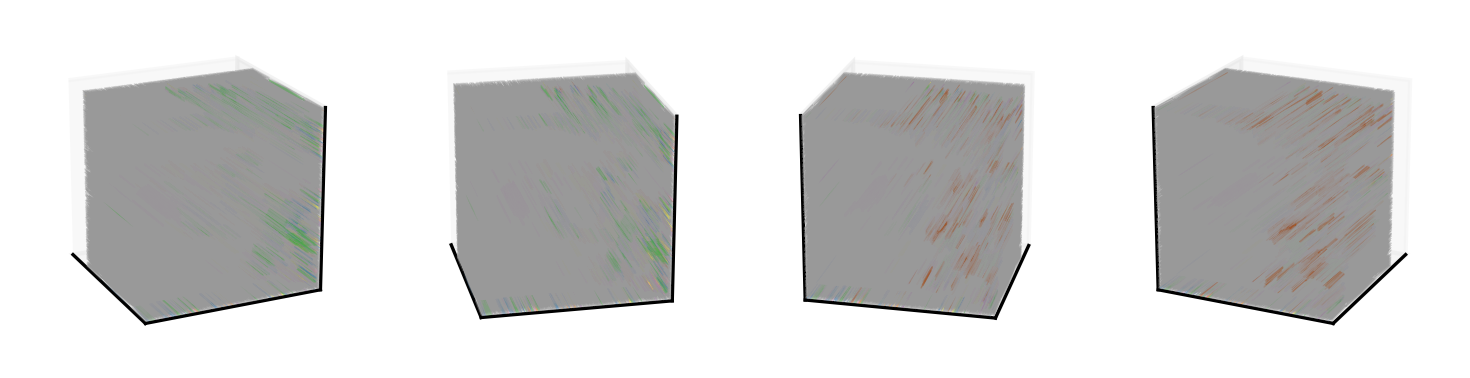

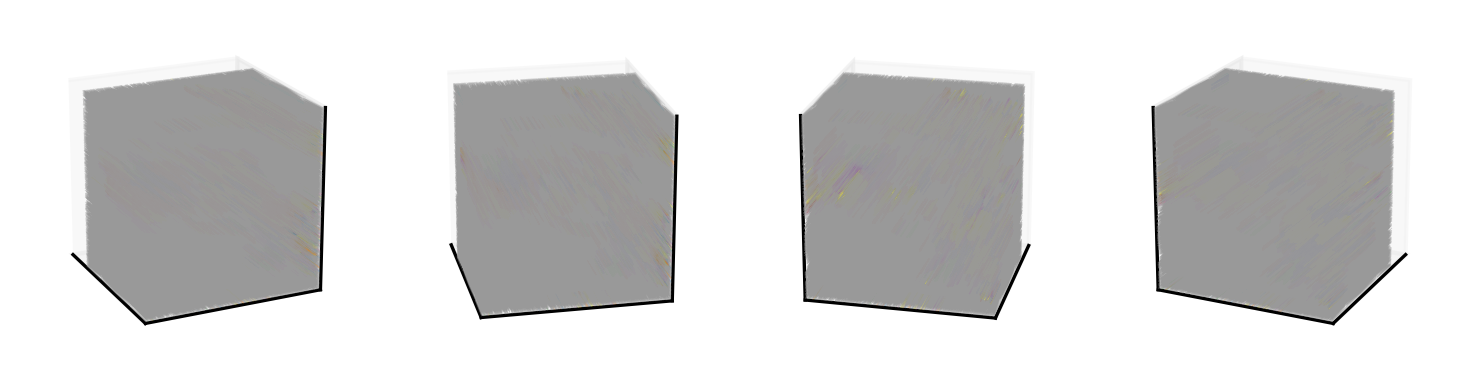

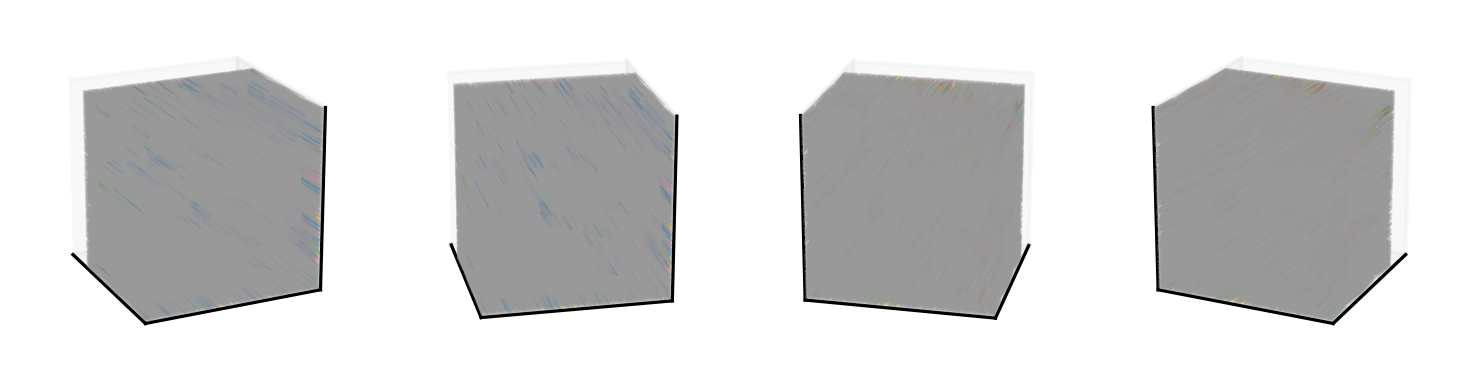

KeyboardInterrupt: 

In [31]:
########################## YOUR CODE IS HERE (3.5p; mandatory) #############################
#
# Implement functionality to make predictions on the test set.
# Plot the results for every image using our earlier defined functions.
#
###########################################################################################

# build test loader
cfg = trainer.cfg
test_ds = cfg.dataset_val_cls(test_df, cfg.val_trf)

test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
trainer.model.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):

        # batch: "scan": (B, S, 3, H, W), "mask": (B, S, 1, H, W)
        # output: (B, S, H, W) with integer class labels
        _, pred_vol, _ = trainer.pass_eval_batch(batch, compute_loss=False)

        # convert to (S,H,W)
        pred_vol = pred_vol.detach().cpu()

        if pred_vol.ndim == 5:
            # (B, S, C, H, W) -> take argmax over C
            pred_vol = pred_vol.argmax(dim=2)

        # now (B, S, H, W)
        pred_vol = pred_vol[0].numpy().astype(np.int32) # (S, H, W)

        # convert predicted mask volume to meshes
        mesh_cache = {}
        for label in np.unique(pred_vol):
            if label == 0:
                continue # skip background
            bin_mask = (pred_vol == label)
            if bin_mask.sum() == 0:
                continue

            verts, faces, normals, values = measure.marching_cubes(bin_mask, level=0.5, step_size=2)
            mesh_cache[int(label)] = (verts, faces)

        # render
        render_3d_mask(mesh_cache=mesh_cache, shape=pred_vol.shape, colors=matplotlib.colormaps["Set1"], elev=200, azim=25, alpha=0.3)